# Sentiment Driven Stock Predictions

## ToDo
* @Nathan add more comments
* @Bryan/ Kevin explore more data preprocessing techniques
* ~~Remove twitter stuff~~
* Pick a sentiment analysis algo - currently randomforrest is working best
* Explore more prediction algorithms
  * Use non-binary classifiers to directly predict time series results instead of a binary algorithm
  * Implement better trading simulation algorithm based on above

---

* Need more news data for more testing
* Add more technical indicators for stock stuff
* Test on more stocks like SPY etc
* Add some analysis of returns

## Importing Data

In [ ]:
# First, mount your drive (might happen automatically)
from google.colab import drive
drive.mount('/content/drive')

!nvidia-smi

Mounted at /content/drive
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



### First time downloading data to drive

In [ ]:
## First time import to transfer data from kaggle to Google Drive

## alternatively just download a dataset and upload it to your google drive

## Generate an API key using the instructions on this site - https://medium.com/analytics-vidhya/how-to-directly-download-kaggle-dataset-to-google-drive-aa06175712e2
## Next, on the files tab on the left browse to content and transfer the downloaded files from /content to "MyDrive"

#  import os

# os.environ['KAGGLE_USERNAME'] = "your username"
# os.environ['KAGGLE_KEY'] = "your api key"

# !kaggle datasets download -d aaron7sun/stocknews

### Normal data import

In [ ]:
# Once data has already been transferred, use this to import data from your drive

!cp '/content/drive/MyDrive/ECE 579 Project/stooq_all_us_daily_data.zip' .
!cp '/content/drive/MyDrive/ECE 579 Project/stocknews.zip' .
#!cp '/content/drive/MyDrive/ECE 579/ECE579_TermProject/Code/Data/tweets-about-the-top-companies-from-2015-to-2020.zip' .

# make folder structure
!mkdir stock_data
!mkdir stock_news
#!mkdir tweets

# unzip files
!unzip -q stooq_all_us_daily_data.zip -d stock_data
#!unzip -q tweets-about-the-top-companies-from-2015-to-2020 -d tweets
!unzip -q stocknews.zip -d stock_news

!ls

drive	     stock_data  stocknews.zip
sample_data  stock_news  stooq_all_us_daily_data.zip


In [36]:
r_data

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...
...,...,...
73603,2008-06-08,b'Man goes berzerk in Akihabara and stabs ever...
73604,2008-06-08,b'Threat of world AIDS pandemic among heterose...
73605,2008-06-08,b'Angst in Ankara: Turkey Steers into a Danger...
73606,2008-06-08,"b""UK: Identity cards 'could be used to spy on ..."


In [37]:
df

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

In [18]:
import pandas as pd

#reshape reddit data to match news headlines

r_data =  pd.read_csv('/content/stock_news/RedditNews.csv')
foo = lambda a: " / ".join(a) 
reddit_data = r_data.groupby(by=['Date']).agg({'News':foo}).reset_index()
reddit_data

,Date,News
0,2008-06-08,b'Nim Chimpsky: The tragedy of the chimp who t...
1,2008-06-09,b'United States quits Human Rights Council' / ...
2,2008-06-10,"b'Oil shortage a myth, says industry insider' ..."
3,2008-06-11,b'BBC uncovers lost Iraq billions' / b'War Cri...
4,2008-06-12,"b'Did US attack Pakistan last night? ""Pakistan..."
...,...,...
2938,2016-06-27,Barclays and RBS shares suspended from trading...
2939,2016-06-28,"2,500 Scientists To Australia: If You Want To ..."
2940,2016-06-29,Explosion At Airport In Istanbul / Yemeni form...
2941,2016-06-30,Jamaica proposes marijuana dispensers for tour...


### Stock data class

In [33]:
# class for stock data
import os
import pandas as pd
from datetime import datetime, date
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt 
%matplotlib inline

class Stock_data():
  
  def __init__(self, symbol, historical = True, timeframe = 'daily', source_folder = '/content/stock_data/data/daily/us'):
    self.symbol = symbol + '.us.txt'
    self.historical = historical
    self.timeframe = timeframe
    self.source_folder = source_folder
    self.data = pd.DataFrame()

    # get csv path from symbol by searching
    for root, dirs, files in os.walk(self.source_folder):
      if self.symbol in files:
        self.csv_path = os.path.join(root, self.symbol)

    if not self.csv_path:
      print('Error, symbol not found')
  
    # import data
    if historical == True & bool(timeframe == 'daily'):
      self.import_data()

  # function for importing data
  def import_data(self):
    self.data = pd.read_csv(self.csv_path, parse_dates=['<DATE>'],
                            date_parser=lambda x: datetime.strptime(x, '%Y%m%d')) #index_col = '<DATE>', 

  # removes excess columns
  def clean_data(self):
    del self.data['<TICKER>']
    del self.data['<PER>']
    del self.data['<OPENINT>']
    del self.data['<TIME>']

  # gets data from a range of dates
  def get_daterange(self, start_date, end_date, data = 0):
    if data:
      temp_data = data
    else:
      temp_data = data

    temp_data = temp_data.loc[(temp_data['<DATE>'] <= end_date) & (temp_data['<DATE>'] >= start_date)]
    temp_data = temp_data.reset_index()
    return temp_data

  # returns input data with a binary label depending on if the stock price went up or down that day
  def get_binarylabel(self, data):
    if data:
      temp_data = data
    else:
      temp_data = data

    temp_data.loc[temp_data['<CLOSE>'] - temp_data['<OPEN>'] > 0, 'Label'] = int(1)
    temp_data.loc[temp_data['<CLOSE>'] - temp_data['<OPEN>'] <= 0, 'Label'] = int(0)
    return temp_data

  def get_laggedbinarylabel(self, lag=1, data = 0):
    if data:
      temp_data = data
    else:
      temp_data = data

    temp_data.loc[temp_data['<CLOSE>'] - temp_data['<OPEN>'] > 0, 'Label'] = int(1)
    temp_data.loc[temp_data['<CLOSE>'] - temp_data['<OPEN>'] <= 0, 'Label'] = int(0)
    return temp_data

  def get_renamed(self):
    return self.data.rename(columns = {'<DATE>':'Date', '<OPEN>':'Open', '<HIGH>':'High', '<LOW>':'Low', '<CLOSE>':'Close', '<VOL>':'Vol'}, inplace = True) 

  def set_data(self, dataframe):
    self.data = dataframe

  def get_data(self):
    return self.data


# function to report performance metrics
def report(labels, predictions):

  # Report accuracy on test data
  matrix = confusion_matrix(labels, predictions)
  print('Confusion Matrix')
  print(matrix)
  print()
  score = accuracy_score(labels, predictions)
  print('Overall prediction accuracy: ' + str(score) + '\n')
  report = classification_report(labels, predictions)
  print('Classification Report: ')
  print(report)


In [42]:
# import stock data by setting up data class
# imports djia data (dia etf)
dia_data = Stock_data('dia')
# uses clean function of data class to remove excess columns
dia_data.clean_data()

# same for s&p 500 (spy etc) dataset
spy_data = Stock_data('spy')
spy_data.clean_data()

# same for nasdaq (qqq)
qqq_data = Stock_data('qqq')
qqq_data.clean_data()

# make sure data looks right
print(dia_data.data)

         <DATE>    <OPEN>    <HIGH>    <LOW>  <CLOSE>     <VOL>
0    2005-02-25   87.6640   88.4780   87.571   88.428   6101982
1    2005-02-28   88.2250   88.9380   87.535   87.891   9135557
2    2005-03-01   87.9500   88.5290   87.950   88.324   6510615
3    2005-03-02   87.9850   88.7010   87.932   88.192   9343052
4    2005-03-03   88.4780   88.6830   87.836   88.341  10124004
...         ...       ...       ...      ...      ...       ...
4009 2021-02-01  302.2800  303.3500  300.140  302.020   3138644
4010 2021-02-02  304.5399  308.4300  304.520  306.820   3090522
4011 2021-02-03  306.1000  307.9353  305.180  307.260   2087820
4012 2021-02-04  307.8500  310.6700  307.770  310.670   2638783
4013 2021-02-05  312.3600  312.5500  310.870  311.540   1955091

[4014 rows x 6 columns]


## Sentiment Analysis

In [21]:
# Displaying news headlines dataset

df = pd.read_csv('stock_news/Combined_News_DJIA.csv')
df

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

### News

#### Random Forrest/ Bag of Words

In [30]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

class RandomForrestSentiment():

  def __init__(self, stock_dataset, news_dataset_path = 'stock_news/Combined_News_DJIA.csv'):
    self.news_path = news_dataset_path
    self.stock_data = stock_dataset
    self.news_data = pd.read_csv(news_dataset_path)

# -----------------------------------------------------------------------------------
  #DATA PREP
  # sets up news dataset for random forrest
  def prepare_news_data(self, data = 0, label = 'source'):
    if label != 'source':
    # allows using next day's stock change by providing stock dataframe, can make this better
      if data:
        self.news_data['Label']  = data['Label'].astype(int)

    # split data
    self.train = self.news_data[self.news_data['Date'] < '20150101']
    self.test = self.news_data[self.news_data['Date'] > '20141231']

    # remove extra indices
    self.data = self.train.iloc[:, 2:27]

    # remove non alphabetical characters
    self.data.replace("[^a-zA-Z]", " ", regex=True, inplace=True)

    # rename columns
    list1 = [i for i in range(25)]
    new_Index = [str(i) for i in list1]
    self.data.columns = new_Index

    # make everything lowercase
    for index in new_Index:
        self.data[index] = self.data[index].str.lower()

    # create list for each row merging all headlines into one
    self.headlines = []
    for row in range(0, len(self.data.index)):
        self.headlines.append(' '.join(str(x) for x in self.data.iloc[row, 0:25]))

  def prepare_reddit_data(self):
    self.r_data =  pd.read_csv('/content/stock_news/RedditNews.csv')
    foo = lambda a: " / ".join(a) 
    self.reddit_data = self.r_data.groupby(by=['Date']).agg({'News':foo}).reset_index()
    
    self.reddit_data.replace("[^a-zA-Z]", " ", regex=True, inplace=True)
    self.reddit_data['News'].str.lower()

    self.r_headlines = []
    for row in range(0, len(self.reddit_data)):
      self.r_headlines.append(' '.join(str(x) for x in self.reddit_data.iloc[row, 0:25]))


# -----------------------------------------------------------------------------------
  #TOKENIZATION
  def tokenize_data(self, bag = True, ngrams = 2):
    # convert all sentences into vectors
    self.countVector = CountVectorizer(ngram_range=(ngrams, ngrams))
    #ngram(2,2) means it will combine the 2 words together and assign the value

    # bag of words
    if bag:
      self.trainDataset = self.countVector.fit_transform(self.headlines)

  def train_model(self):
    # Setup random forest classifier and train
    self.randomClassifier = RandomForestClassifier(n_estimators=200, criterion='entropy')
    self.randomClassifier.fit(self.trainDataset, self.train['Label'])

  def test_model(self):
    # predict for test data
    self.testTransform =[]
    for row in range(0, len(self.test.index)):
        self.testTransform.append(' '.join(str(x) for x in self.test.iloc[row, 2:27]))

    self.test_dataset = self.countVector.transform(self.testTransform)
    self.predictions = self.randomClassifier.predict(self.test_dataset)

  def get_performance_report(self):
    report(self.test['Label'], self.predictions)


In [41]:
generic_forrest.predictions

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [39]:
generic_forrest.headlines[1]

'b why wont america and nato help us  if they wont help us now  why did we help them in iraq   b bush puts foot down on georgian conflict  b jewish georgian minister  thanks to israeli training  we re fending off russia   b georgian army flees in disarray as russians advance   gori abandoned to russia without a shot fired  b olympic opening ceremony fireworks  faked   b what were the mossad with fraudulent new zealand passports doing in iraq   b russia angered by israeli military sale to georgia  b an american citizen living in s ossetia blames u s  and georgian leaders for the genocide of innocent people  b welcome to world war iv  now in high definition   b georgia s move  a mistake of monumental proportions   b russia presses deeper into georgia  u s  says regime change is goal  b abhinav bindra wins first ever individual olympic gold medal for india  b  u s  ship heads for arctic to define territory  b drivers in a jerusalem taxi station threaten to quit rather than work for their 

In [29]:
generic_forrest = RandomForrestSentiment(spy_data)
generic_forrest.prepare_news_data()
generic_forrest.tokenize_data()
generic_forrest.train_model()
generic_forrest.test_model()
generic_forrest.get_performance_report()

Confusion Matrix
[[146  40]
 [ 18 174]]

Overall prediction accuracy: 0.8465608465608465

Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       186
           1       0.81      0.91      0.86       192

    accuracy                           0.85       378
   macro avg       0.85      0.85      0.85       378
weighted avg       0.85      0.85      0.85       378



### DistilBERT

In [ ]:
# Prep all data for headlines
# remove extra indices

data = df.iloc[:, 2:27]

# remove non alphabetical characters
data.replace("[^a-zA-Z]", " ", regex=True, inplace=True)

# rename columns
list1 = [i for i in range(25)]
new_Index = [str(i) for i in list1]
data.columns = new_Index

# make everything lowercase
for index in new_Index:
    data[index] = data[index].str.lower()

# create list for each row merging all headlines into one
news_headlines = []
for row in range(0, len(data.index)):
    news_headlines.append(' '.join(str(x) for x in data.iloc[row, 0:25]))

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.9MB 18.8MB/s 
     |████████████████████████████████| 890kB 49.9MB/s 
     |████████████████████████████████| 3.2MB 44.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=5464ea22688acf34a5fde3a97df4fd08b477fb31bdef68e996370667058ce4d6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE = 1e-05

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)
# tokenizer = Tokenizer.from_pretrained('distilgpt2', truncation=True, do_lower_case=True)

In [ ]:
class LabelDataset(Dataset):

  def __init__(self, dataframe, tokenizer, max_len):
    self.tokenizer = tokenizer
    self.data = dataframe
    self.text = dataframe.Headlines
    self.targets = self.data.Labels
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, index):
    text = str(self.text[index])
    text = " ".join(text.split())

    inputs = self.tokenizer.encode_plus(
      text,
      None,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True,
      return_token_type_ids=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs["token_type_ids"]


    return {
      'ids': torch.tensor(ids, dtype=torch.long),
      'mask': torch.tensor(mask, dtype=torch.long),
      'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
      'targets': torch.tensor(self.targets[index], dtype=torch.float)
    }

In [ ]:
# Creating the dataset and dataloader for the neural network
train_dat = pd.DataFrame()
train_dat['Headlines'] = news_headlines
train_dat['Labels'] = df['Label']
# train_dat['Labels'] = stock_lagged['Label']
# train_dat['Labels'] = generic_forrest.news_data['Label']
train_dat['Labels'] = train_dat.iloc[:, 1:].values.tolist()
train_dat['Date'] = df['Date']
train_dat

new_df = train_dat

# train_size = 0.8
# train_data=new_df.sample(frac=train_size,random_state=200)
# test_data=new_df.drop(train_data.index).reset_index(drop=True)
# train_data = train_data.reset_index(drop=True)

# Split data
train_data = new_df[new_df['Date'] < '2014-10-01']
test_data = new_df[new_df['Date'] >= '2014-10-01']
# test_data = new_df.loc[(new_df['Date'] >= '2014-10-01') & (new_df['Date'] <= '2015-07-01')]
# val_data = new_df[new_df['Date'] > '2015-07-01']

del train_data['Date']
del test_data['Date']
# del val_data['Date']

test_data = test_data.reset_index()
# val_data = val_data.reset_index()

print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))
# print("VAL Dataset: {}".format(val_data.shape))

training_set = LabelDataset(train_data, tokenizer, MAX_LEN)
testing_set = LabelDataset(test_data, tokenizer, MAX_LEN)
# validation_set = LabelDataset(val_data, tokenizer, MAX_LEN)

FULL Dataset: (1989, 3)
TRAIN Dataset: (1547, 2)
TEST Dataset: (442, 3)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)
# validation_loader = DataLoader(validation_set, ** val_params)

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
# Example source: https://colab.research.google.com/github/DhavalTaunk08/Transformers_scripts/blob/master/Transformers_multilabel_distilbert.ipynb#scrollTo=FeftvDhjDSPp

class DistilBERTClass(torch.nn.Module):
  def __init__(self):
    super(DistilBERTClass, self).__init__()
    # self.l1 = DistilBertModel.from_pretrained("distilgpt2")
    self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
    self.pre_classifier = torch.nn.Linear(768, 768)
    self.dropout = torch.nn.Dropout(0.1)
    self.classifier = torch.nn.Linear(768, 1)

  def forward(self, input_ids, attention_mask, token_type_ids):
    output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
    hidden_state = output_1[0]
    pooler = hidden_state[:, 0]
    pooler = self.pre_classifier(pooler)
    pooler = torch.nn.Tanh()(pooler)
    pooler = self.dropout(pooler)
    output = self.classifier(pooler)
    return output

model = DistilBERTClass()
model.to(device)

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

In [ ]:
def loss_fn(outputs, targets):
  return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

def train_model(epoch):
  model.train()
  for _,data in tqdm(enumerate(training_loader, 0)):
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)

    outputs = model(ids, mask, token_type_ids)

    optimizer.zero_grad()
    loss = loss_fn(outputs, targets)
    if _%5000==0:
      print(f'Epoch: {epoch}, Loss:  {loss.item()}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
for epoch in range(EPOCHS):
    train_model(epoch)

1it [00:00,  3.38it/s]

Epoch: 0, Loss:  0.6995131373405457


387it [01:33,  4.12it/s]
1it [00:00,  4.38it/s]

Epoch: 1, Loss:  0.7472215294837952


387it [01:34,  4.09it/s]
1it [00:00,  4.29it/s]

Epoch: 2, Loss:  0.752421498298645


387it [01:34,  4.09it/s]
1it [00:00,  4.34it/s]

Epoch: 3, Loss:  0.35861483216285706


387it [01:35,  4.07it/s]
1it [00:00,  4.30it/s]

Epoch: 4, Loss:  0.04436396434903145


387it [01:35,  4.07it/s]


In [ ]:
def validation(testing_loader):
  model.eval()
  fin_targets=[]
  fin_outputs=[]
  with torch.no_grad():
    for _, data in tqdm(enumerate(testing_loader, 0)):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)
      outputs = model(ids, mask, token_type_ids)
      fin_targets.extend(targets.cpu().detach().numpy().tolist())
      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
  return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation(testing_loader)

# val_out, val_targets = validation(validation_loader)
# val_outputs = np.array(val_out) >= 0.5

final_outputs = np.array(outputs) >=0.5

111it [00:10, 10.60it/s]


In [ ]:
# Saving the files to drive

output_model_file = "/content/drive/MyDrive/ECE 579 Project/models/distilbert_model_newslabels.bin"
output_vocab_file = "/content/drive/MyDrive/ECE 579 Project/models/vocab_newslabels.bin"

torch.save(model, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('Saved')

Saved


In [ ]:
report(targets, final_outputs.astype(int))

Confusion Matrix
[[ 68 146]
 [ 79 149]]

Overall prediction accuracy: 0.49095022624434387

Classification Report: 
              precision    recall  f1-score   support

         0.0       0.46      0.32      0.38       214
         1.0       0.51      0.65      0.57       228

    accuracy                           0.49       442
   macro avg       0.48      0.49      0.47       442
weighted avg       0.48      0.49      0.48       442



In [ ]:
# report(val_targets, val_outputs.astype(int))

### Vadersentiment

In [46]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 16.8MB/s 


In [47]:
# Prep all data for headlines
# remove extra indices

data = df.iloc[:, 2:27]

# remove non alphabetical characters
data.replace("[^a-zA-Z]", " ", regex=True, inplace=True)

# rename columns
list1 = [i for i in range(25)]
new_Index = [str(i) for i in list1]
data.columns = new_Index

# make everything lowercase
for index in new_Index:
    data[index] = data[index].str.lower()

# create list for each row merging all headlines into one
news_headlines = []
for row in range(0, len(data.index)):
    news_headlines.append(' '.join(str(x) for x in data.iloc[row, 0:25]))

In [48]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_analyzer = SentimentIntensityAnalyzer()
out = []

# use headlines list from generic_forrest
for item in range(0, len(news_headlines)):
  out.append(vader_analyzer.polarity_scores(news_headlines[item]))

vader_output = pd.DataFrame(out, columns=['neg', 'neu', 'pos', 'compound'])

## XGBoost Stuff

In [43]:
def xgboost_data_gen(stock_data):
  # Building input data - including stock data, sentiment, technical indicators (RSI/ MA/ etc.)
  # stock data
  start_date = '2008-08-08'
  end_date = '2016-06-28'
  test_stock_data = stock_data.data
  test_stock_data = test_stock_data.loc[(test_stock_data['<DATE>'] >= start_date) & (test_stock_data['<DATE>'] <= end_date)]
  test_stock_data = test_stock_data.reset_index()

  # random forrest output
  rf_labels = pd.DataFrame(df['Label'].loc[(df['Date'] < '20141231')])
  rf_labels = rf_labels['Label'].append(pd.Series(name = 'Label', data = generic_forrest.predictions), ignore_index = True)
  rf_labels = rf_labels.rename('RandomForrest')

  # technical indicators
  # moving average columns
  test_stock_data['MA5'] = test_stock_data['<CLOSE>'].rolling(window=5).mean()
  test_stock_data['MA10'] = test_stock_data['<CLOSE>'].rolling(window=10).mean()
  test_stock_data['MA20'] = test_stock_data['<CLOSE>'].rolling(window=20).mean()
  test_stock_data['MA50'] = test_stock_data['<CLOSE>'].rolling(window=50).mean()
  test_stock_data['MA200'] = test_stock_data['<CLOSE>'].rolling(window=200).mean()

  # Force Index (ForceIndex)
  test_stock_data['FI'] = test_stock_data['<CLOSE>'].diff(1) * test_stock_data['<VOL>']

  # final concat of data inputs    
  xgboost_data = pd.concat([vader_output, test_stock_data, rf_labels], axis=1, join='inner')
  # rename columns since xgboost doesn't like <>
  xgboost_data.rename(columns = {'<DATE>':'Date', '<OPEN>':'Open', '<HIGH>':'High', '<LOW>':'Low', '<CLOSE>':'Close', '<VOL>':'Vol'}, inplace = True)
  # get rid of old index
  del xgboost_data['index']

  # make sure data looks good
  return xgboost_data

In [ ]:
def xgboost_split(xg_data):

  # split into test and train around 2014-10-01
  X_train = xg_data[xg_data['Date'] < '2015-01-01']
  del X_train['Date']
  X_test = xg_data[xg_data['Date'] >= '2015-01-01']
  del X_test['Date']
  y_train = df[df['Date'] < '2014-12-31']['Label']
  y_test = df[df['Date'] >= '2014-12-31']['Label']

  # remove some extra data pieces.... (not sure why these are here)
  y_test.pop(1985)
  y_test.pop(1986)
  y_test.pop(1987)
  y_test.pop(1988)

  return X_train, X_test, y_train, y_test

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

def xg_train(X_train, X_test, y_train, y_test):
  # setup xgboost classifier (binary classifier)
  model = XGBClassifier(max_depth = 50, n_estimators = 500, learning_rate = 0.01)
  # train model
  model.fit(X_train, y_train)
  # predict test data
  y_pred = model.predict(X_test)
  # display accuracy
  accu_score = accuracy_score(y_test, y_pred)
  print(accu_score)
  print(classification_report(y_pred, y_test))
  return model, y_pred

In [ ]:
import seaborn as sns
import numpy as np

def xg_importance(model):
  # plot feature importance in classifier
  indices = np.argsort(model.feature_importances_)[::-1]

  features = []
  for i in range(10):
      features.append(xgboost_data.columns[indices[i]])

  fig, ax = plt.subplots(figsize=(15,5))     

  sns.barplot(x=features, y=model.feature_importances_[indices[range(10)]],\
  label="Importtant Categorical Features", palette=("Blues_d"),ax=ax).\
  set_title('Categorical Features Importance')

  ax.set(xlabel="Columns", ylabel = "Importance")

In [50]:
xgboost_data_dia = xgboost_data_gen(dia_data)
xgboost_data_dia

,neg,neu,pos,compound,Date,Open,High,Low,Close,Vol,MA5,MA10,MA20,MA50,MA200,FI,RandomForrest
0,0.221,0.741,0.039,-0.9982,2008-08-08,93.219,96.008,93.057,95.446,38254036,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.172,0.746,0.082,-0.9837,2008-08-11,95.483,96.908,95.307,96.136,27554381,NaN,NaN,NaN,NaN,NaN,1.901252e+07,1
2,0.116,0.832,0.052,-0.9679,2008-08-12,95.841,95.901,94.717,95.121,27502355,NaN,NaN,NaN,NaN,NaN,-2.791489e+07,0
3,0.139,0.800,0.061,-0.9818,2008-08-13,94.717,94.813,93.608,94.189,34546335,NaN,NaN,NaN,NaN,NaN,-3.219718e+07,0
4,0.175,0.728,0.097,-0.9850,2008-08-14,93.738,95.744,93.608,94.992,30158885,95.1768,NaN,NaN,NaN,NaN,2.421758e+07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,0.196,0.751,0.053,-0.9979,2016-06-22,164.530,165.170,163.780,163.920,3205796,163.7500,163.801,164.1290,163.6164,157.13315,-1.442608e+06,1
1981,0.112,0.815,0.072,-0.9833,2016-06-23,165.220,165.970,164.920,165.970,3167600,164.2500,163.828,164.2155,163.6532,157.21755,6.493580e+06,1
1982,0.160,0.754,0.087,-0.9897,2016-06-24,161.120,163.080,159.970,160.270,12324106,163.7320,163.391,164.0260,163.5724,157.28425,-7.024740e+07,1
1983,0.096,0.855,0.049,-0.9167,2016-06-27,159.180,159.180,157.260,158.010,8327343,162.5080,162.852,163.7045,163.4520,157.33560,-1.881980e+07,1


In [ ]:
xgboost_data_dia = xgboost_data_gen(dia_data)
xgboost_data_spy = xgboost_data_gen(spy_data)
xgboost_data_qqq = xgboost_data_gen(qqq_data)

X_train_dia, X_test_dia, y_train_dia, y_test_dia = xgboost_split(xgboost_data_dia)
X_train_spy, X_test_spy, y_train_spy, y_test_spy = xgboost_split(xgboost_data_spy)
X_train_qqq, X_test_qqq, y_train_qqq, y_test_qqq = xgboost_split(xgboost_data_qqq)

dia_model, dia_pred = xg_train(X_train_dia, X_test_dia, y_train_dia, y_test_dia)
spy_model, spy_pred = xg_train(X_train_spy, X_test_spy, y_train_spy, y_test_spy)
# qqq_model, qqq_pred = xg_train(X_train_qqq, X_test_qqq, y_train_qqq, y_test_qqq)

0.8693333333333333
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       138
           1       1.00      0.79      0.88       237

    accuracy                           0.87       375
   macro avg       0.87      0.90      0.87       375
weighted avg       0.90      0.87      0.87       375

0.8693333333333333
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       138
           1       1.00      0.79      0.88       237

    accuracy                           0.87       375
   macro avg       0.87      0.90      0.87       375
weighted avg       0.90      0.87      0.87       375



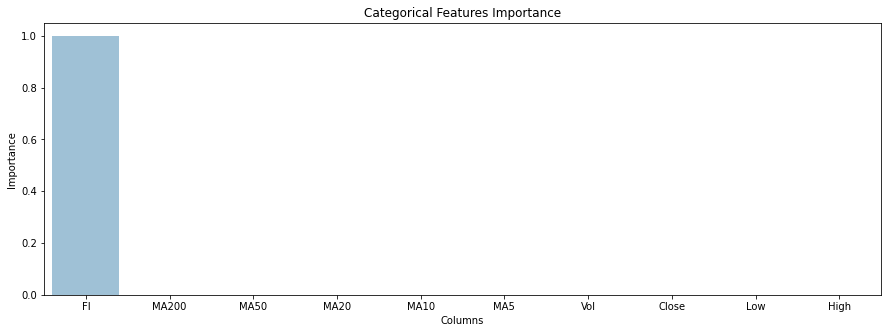

In [ ]:
xg_importance(dia_model)

In [ ]:
# setup data for regressor
# remove close/ open price from X_train and use them for y_train etc.
reg_y_train = X_train.Close
reg_y_test = X_test.Close

reg_y_train = reg_y_train.shift(1).reset_index()
reg_y_test = reg_y_test.shift(1).reset_index()

reg_X_train = X_train
reg_X_test = X_test

del reg_X_train['Close']
del reg_y_train['index']
del reg_X_test['Close']
del reg_y_test['index']

[16:50:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


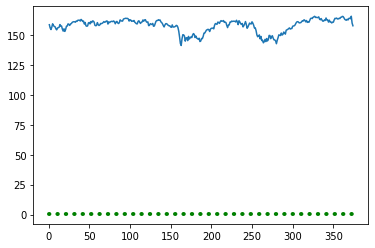

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE

reg_model = XGBRegressor()
reg_model.fit(X_train, reg_y_train)
reg_pred = reg_model.predict(X_test)
rmse = np.sqrt(MSE(reg_y_test, reg_pred))
print("RMSE : % f" %(rmse))

plot_out = reg_y_test.to_list()

plt.plot(range(0, len(reg_pred)), reg_pred, linestyle = (0,(0.1,2)), dash_capstyle = 'round', linewidth = 4, color = 'Green')
plt.plot(plot_out)
plt.show()

[Text(0, 0.5, 'Importance'), Text(0.5, 0, 'Columns')]

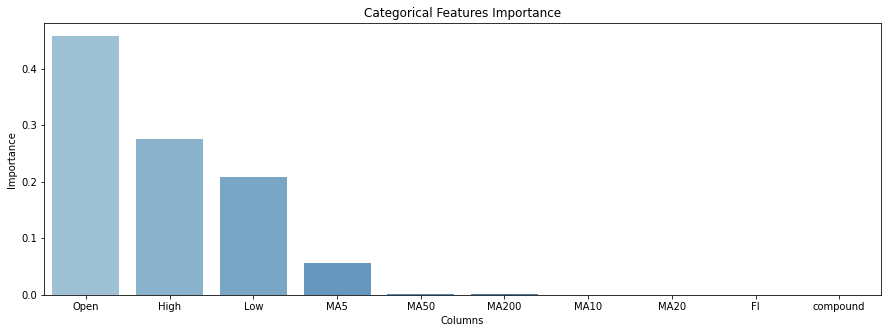

In [ ]:
import seaborn as sns
import numpy as np

# plot feature importance in classifier
indices = np.argsort(reg_model.feature_importances_)[::-1]

features = []
for i in range(10):
    features.append(X_train.columns[indices[i]])

fig, ax = plt.subplots(figsize=(15,5))     

sns.barplot(x=features, y=reg_model.feature_importances_[indices[range(10)]],\
label="Importtant Categorical Features", palette=("Blues_d"),ax=ax).\
set_title('Categorical Features Importance')

ax.set(xlabel="Columns", ylabel = "Importance")

## ARIMA

In [32]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 18.4MB/s 
     |████████████████████████████████| 2.1MB 41.2MB/s 
     |████████████████████████████████| 9.5MB 37.4MB/s 
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


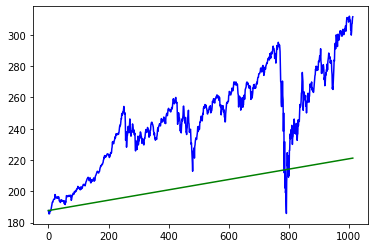

In [35]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load/split your data
arima_train, arima_test = train_test_split(dia_data.data['<CLOSE>'], train_size=3000)

# Fit your model
arima_model = pm.auto_arima(arima_train, seasonal=False, m=12)

# make your forecasts
arima_predictions = arima_model.predict(arima_test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(arima_test.shape[0])
plt.plot(x, arima_test, c='blue')
plt.plot(x, arima_predictions, c='green')
plt.show()

### K-folds

In [ ]:
import numpy as np
from sklearn.model_selection import KFold

data = dia_data.data['<CLOSE>']
X_data = data
Y_Data = data.shift(1)

kf = KFold(n_splits=10)
kf.get_n_splits(X_data)

kfold_pred = np.empty(shape=(0, len(X_data)))

print(kf)
KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X_data):
  print("TRAIN:", train_index, "TEST:", test_index)
  x_train, X_test = X_data[train_index], X_data[test_index]
  y_train, y_test = Y_Data[train_index], Y_Data[test_index]

  # ARIMA
  # Fit your model
  arima_model = pm.auto_arima(x_train, seasonal=False, m=12)

  # make your forecasts
  arima_predictions = arima_model.predict(X_test.shape[0])  # predict N steps into the future

  kfold_pred = arima_predictions


KFold(n_splits=10, random_state=None, shuffle=False)
TRAIN: [ 402  403  404 ... 4011 4012 4013] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 2

/usr/local/lib/python3.7/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


AttributeError: ignored

In [ ]:
arima_predictions.shape[0]

402

In [ ]:
kfold_pred[slice(None, arima_predictions.shape[0])] = arima_predictions
kfold_pred = slice(None, kfold_pred[0])

ValueError: ignored

## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM



## Stock Backtesting Stuff

### Simple vectorized estimates

* Long model buys when sentiment is positive, sells when not
* Long short model buys when sentiment is positive and shorts when it is negative 

In [ ]:
#class Backtesting():
#   def __init__(self, stock_data, label_data, initial_value):
#     self.stock = stock_data
#     self.label = label_data
#     self.output_df = self.stock
#     self.init_val = initial_value
#     self.liquid = True
#     self.shares = 0
#     self.cur_val = self.init_val


In [ ]:
import numpy as np

# Vectorized simple solution in function form, class to follow after expansion including plotting etc.
def simple_backtest(start_date, predictions, stock_data, end_date = '2016-07-01'):
  test_stock_data = stock_data.loc[(stock_data['<DATE>'] >= start_date) & (stock_data['<DATE>'] <= end_date)]
  test_stock_data = stock_data[stock_data['<DATE>'] > start_date]
  test_stock_data = test_stock_data.reset_index()

  pred_df = pd.DataFrame(predictions, columns=['Sentiment'])
  pred_df['Open'] = test_stock_data['<OPEN>']
  pred_df['Close'] = test_stock_data['<CLOSE>']
  pred_df['Date'] = test_stock_data['<DATE>']
  # Shift percent change so that the next day's percent change is in line with the sentiment
  pred_df['Change'] = pred_df['Close'].pct_change().shift(-1).dropna()
  # Setup column for changes that our position will be exposed to (while we're bought in)
  pred_df['Pos_change'] = pred_df['Sentiment'] * pred_df['Change']
  # Setup column for long and short returns
  pred_df['Pos_change_shrt'] = pred_df['Change']*(-1) + pred_df['Pos_change']
  # Calculate cumulative return for dow jones, long positions, and long/short positions
  pred_df['Cumul_ret_dji'] = np.exp(np.log1p(pred_df['Change']).cumsum())
  pred_df['Cumul_ret_long'] = np.exp(np.log1p(pred_df['Pos_change']).cumsum())
  pred_df['Cumul_ret_long_shrt'] = (np.exp(np.log1p(pred_df['Pos_change']).cumsum()) + np.exp(np.log1p(pred_df['Pos_change_shrt']).cumsum()))/2
  return pred_df

In [ ]:
predictions = generic_forrest.predictions
stock_data = dia_data.data.reset_index()
# randomforrest
pred_df_forrest = simple_backtest('2014-12-31', predictions, stock_data)
# xgboost
pred_df_xgboost = simple_backtest('2014-12-31', y_pred, stock_data)
pred_df_xgboost

,Sentiment,Open,Close,Date,Change,Pos_change,Pos_change_shrt,Cumul_ret_dji,Cumul_ret_long,Cumul_ret_long_shrt
0,0,159.56,158.87,2015-01-02,-0.016869,-0.000000,0.016869,0.983131,1.000000,1.008435
1,1,158.12,156.19,2015-01-05,-0.008643,-0.008643,0.000000,0.974633,0.991357,1.004113
2,0,156.39,154.84,2015-01-06,0.012787,0.000000,-0.012787,0.987096,0.991357,0.997611
3,0,156.20,156.82,2015-01-07,0.018174,0.000000,-0.018174,1.005036,0.991357,0.988489
4,1,158.30,159.67,2015-01-08,-0.008831,-0.008831,0.000000,0.996160,0.982602,0.984112
...,...,...,...,...,...,...,...,...,...,...
370,1,164.53,163.92,2016-06-22,0.012506,0.012506,0.000000,1.044691,0.985474,0.956172
371,1,165.22,165.97,2016-06-23,-0.034344,-0.034344,0.000000,1.008812,0.951630,0.939250
372,1,161.12,160.27,2016-06-24,-0.014101,-0.014101,0.000000,0.994587,0.938211,0.932540
373,1,159.18,158.01,2016-06-27,0.015505,0.015505,0.000000,1.010008,0.952758,0.939814


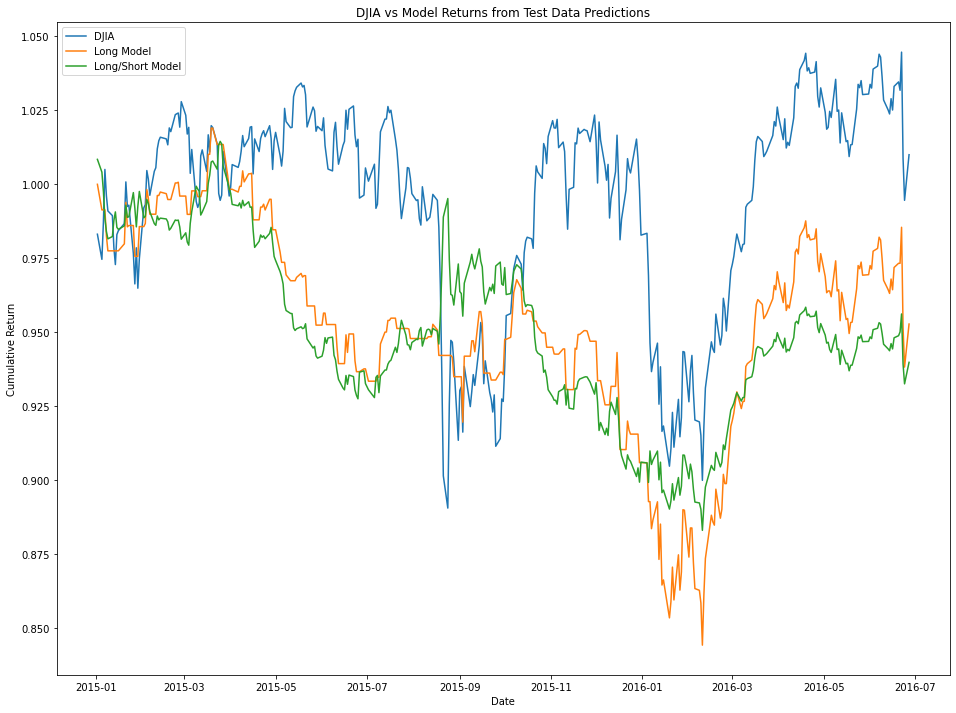

In [ ]:
# Plot results
import matplotlib.pyplot as plt
%matplotlib inline

def plot_backtest(prediction_df, title='DJIA vs Model Returns from Test Data Predictions', label_1='DJIA', label_2='Long Model', label_3='Long/Short Model'):
  pred_df = prediction_df

  plt.figure(figsize=(16, 12)) 
  plt.plot(pred_df['Date'], pred_df['Cumul_ret_dji'], label = label_1)
  plt.plot(pred_df['Date'], pred_df['Cumul_ret_long'], label = label_2)
  plt.plot(pred_df['Date'], pred_df['Cumul_ret_long_shrt'], label = label_3)
  plt.xlabel('Date')
  plt.title(title)
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

plot_backtest(pred_df_xgboost)

In [ ]:
plot_backtest(pred_df_forrest)

In [ ]:
# add indicators to plot for when "trades" occur and when they are correct/ incorrect

In [ ]:
# Print stats for how good the model is including return, sharpe ratio, volatility, max drawdown

In [ ]:
# add a more advanced one which only "trades" if swing is greater than threshold etc.